<h1>Tundmusanalüüs</h1>

<h3>Vajalikud <i>import</i>-id</h3>

In [75]:
import nltk
import os, os.path
import json
import re
import matplotlib.pyplot as plt
import pandas as pd
import random

from tqdm import tqdm
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

In [11]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\taunotam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

<h3>Loeme andmed sisse</h3>

In [12]:
path = 'data_lang/'
data = []

for file in os.listdir(path):
    filename = os.path.join(path, file)
    with open(filename, "r", encoding = 'utf-8') as fin:
        data.append(json.loads(fin.read()))

In [13]:
len(data)

44099

<h3>Tundmusanalüüs - ET</h3>

In [14]:
texts_et = dict()

for post in data:
    if "lang" in post["meta"].keys():
        lang = post["meta"]["lang"]

        if lang == "ET":
            text = post["meta"]["title"] + " " + post["text"]
            text = text.replace('[deleted]', '')
            text = text.replace('[removed]', '')
            text = text.replace('\n', '')
            text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

            texts_et[post["meta"]["created_utc"]] = text

In [15]:
tokenizer = AutoTokenizer.from_pretrained("EMBEDDIA/est-roberta")
model = AutoModelForSequenceClassification.from_pretrained("roBertaSentiment/",local_files_only=True)

max_length = 512
tokenizer.model_max_length = max_length

sentiment_analysis = pipeline(task="sentiment-analysis", model=model, tokenizer=tokenizer)

sentiment = []

for text in texts_et.values():
    sisu = text.replace('\n', '')
    if sisu != '' and sisu != '[deleted]' and sisu != '[removed]':
        sisu = sisu[:max_length - 2]
        result = sentiment_analysis(sisu)[0]
        sentiment.append(result["label"])

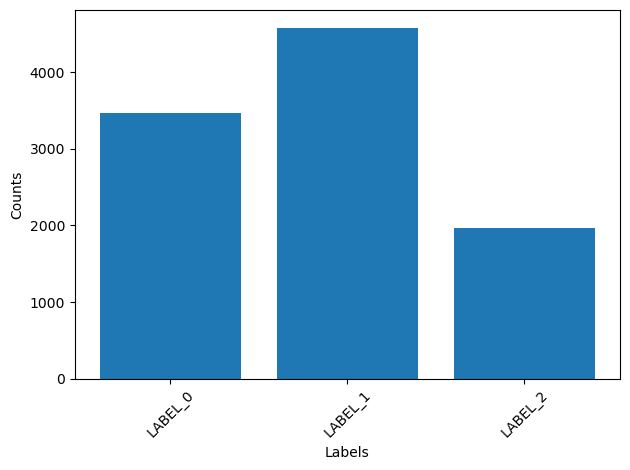

In [16]:
counts = Counter(sentiment)

categories = list(counts.keys())
counts_values = list(counts.values())

sorted_categories = sorted(categories)
sorted_counts_values = [counts[cat] for cat in sorted_categories]

# Create bar plot with sorted categories and counts_values
plt.bar(sorted_categories, sorted_counts_values)

plt.xlabel('Labels')
plt.ylabel('Counts')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h5>Vaatame, kas ja kuidas on tundmus muutunud ajas</h5>

In [17]:
stacked_dict_sentiment = dict()
stacked_dict_sentiment["label"] = []
stacked_dict_sentiment["year"] = []

texts_et_ajad = list(texts_et.keys())

for i in range(len(sentiment)):
    label = sentiment[i]
    if texts_et_ajad[i][:4] != "2023":
        stacked_dict_sentiment["label"].append(label)
        stacked_dict_sentiment["year"].append(texts_et_ajad[i][:4])

In [18]:
cross_tab_prop = pd.crosstab(index=stacked_dict_sentiment['year'],
                             columns=stacked_dict_sentiment["label"],
                             normalize="index")

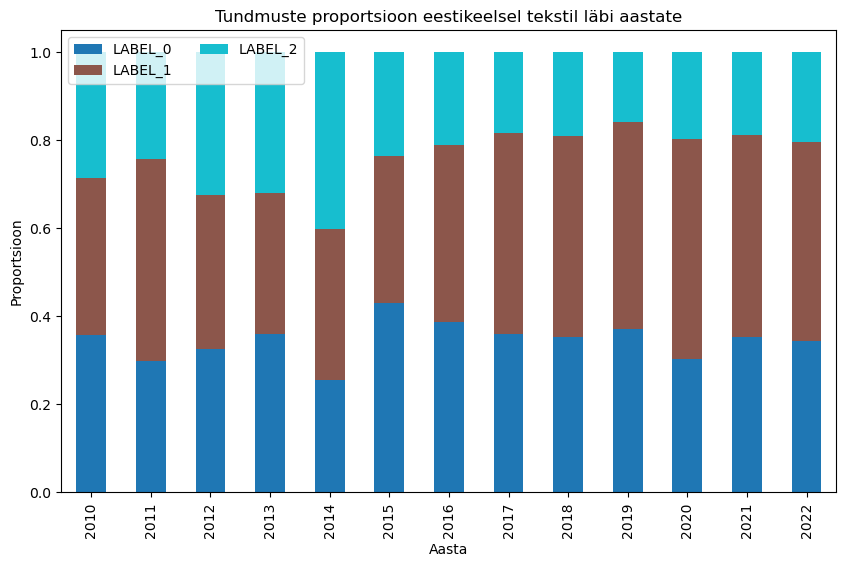

In [19]:
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Aasta")
plt.ylabel("Proportsioon")
plt.title("Tundmuste proportsioon eestikeelsel tekstil läbi aastate")
plt.show()

<h3>Tundmusanalüüs - EN - kasutades VADER-it</h3>

In [65]:
texts_en = dict()

for post in data:
    if "lang" in post["meta"].keys():
        lang = post["meta"]["lang"]

        if lang == "EN":
            text = post["meta"]["title"] + " " + post["text"]
            text = text.replace('[deleted]', '')
            text = text.replace('[deleted by user]', '')
            text = text.replace('[removed]', '')
            text = text.replace('[ Removed by Reddit ]', '')
            text = text.replace('\n', '')
            text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

            texts_en[post["meta"]["created_utc"]] = text

In [67]:
sentiment_sia_en = []
sentiment_sia_en_texts = []
for text in texts_en.values():
    sisu = text.replace('\n', '')
    if sisu != '' and sisu != ' ' and sisu != '[deleted]' and sisu != '[removed]':
        sentiment_sia_en_texts.append(sisu)
        analysis = SIA().polarity_scores(sisu)
        if analysis['compound'] > 0:
            sentiment_sia_en.append('LABEL_2')
        elif analysis['compound'] == 0:
            sentiment_sia_en.append('LABEL_1')
        else:
            sentiment_sia_en.append('LABEL_0')

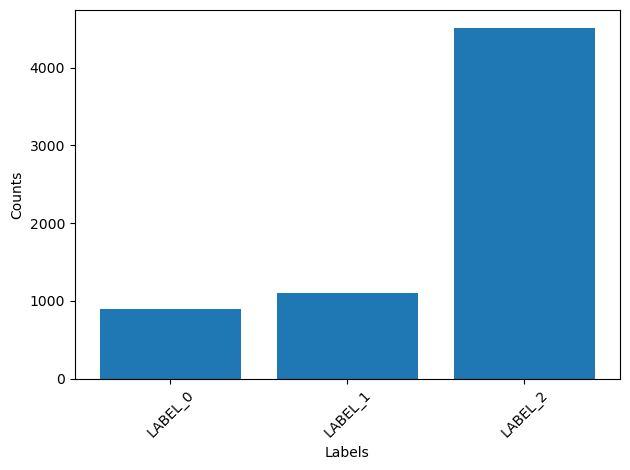

In [68]:
counts = Counter(sentiment_sia_en)

categories = list(counts.keys())
counts_values = list(counts.values())

sorted_categories = sorted(categories)
sorted_counts_values = [counts[cat] for cat in sorted_categories]

plt.bar(sorted_categories, sorted_counts_values)

plt.xlabel('Labels')
plt.ylabel('Counts')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
stacked_dict_sentiment = dict()
stacked_dict_sentiment["label"] = []
stacked_dict_sentiment["year"] = []

texts_en_ajad = list(texts_en.keys())

for i in range(len(sentiment_sia_en)):
    label = sentiment_sia_en[i]
    if texts_et_ajad[i][:4] != "2023":
        stacked_dict_sentiment["label"].append(label)
        stacked_dict_sentiment["year"].append(texts_en_ajad[i][:4])

In [24]:
cross_tab_prop = pd.crosstab(index=stacked_dict_sentiment['year'],
                             columns=stacked_dict_sentiment["label"],
                             normalize="index")

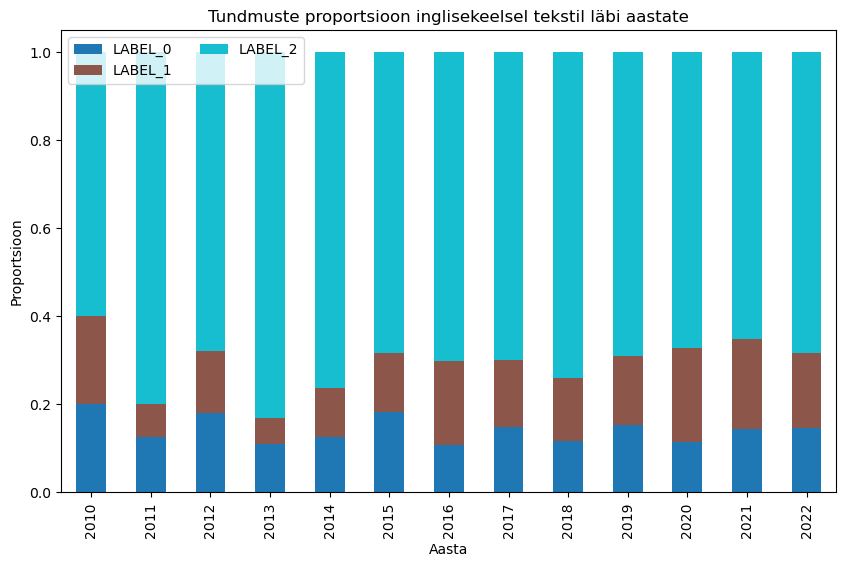

In [25]:
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Aasta")
plt.ylabel("Proportsioon")
plt.title("Tundmuste proportsioon inglisekeelsel tekstil läbi aastate")
plt.show()

<h3>Proovime inglisekeelset roberta mudelit</h3>

In [29]:
!pip install emoji==0.6.0

     ---------------------------------------- 0.0/51.0 kB ? eta -:--:--
     ---------------- ----------------------- 20.5/51.0 kB ? eta -:--:--
     ------------------------------ ------- 41.0/51.0 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 51.0/51.0 kB 374.0 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49745 sha256=00e17322178d5dc93088db73a85df35c6fe882d554302c7a21af4d2274a03e82
  Stored in directory: c:\users\taunotam\appdata\local\pip\cache\wheels\70\2a\7f\1a0012c86b1061c6ee2ed9568b1f830f857a51e8e416452af2
Successfully built emoji


In [41]:
len("Taxis in Estonia… I'm Canadian, and was in Estonia a few years ago. I have some Estonian friends. But none of the Estonians I have asked have been able to answer this question for me, and I've had it for years. Estonia is a small country, so *can an Estonian taxi driver drive you anywhere in Estonia*? Can you name any address in any town in Estonia and be driven there by cab? I don't know why I want to know this so badly, but I'm really curious. Thank you!Yes, I should have asked a cab driver while I was th")

512

In [45]:
import math

In [95]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

max_length = 511
tokenizer.model_max_length = max_length

sentiment_analysis = pipeline(task="sentiment-analysis", model=model, tokenizer=tokenizer)

sentiment_en = []

for text in texts_en.values():
    sisu = text.replace('\n', '')
    if sisu != '' and sisu != ' ' and sisu != '[deleted]' and sisu != '[removed]':
        len_sisu = len(sisu)
        if len_sisu > max_length:
            labels = []
            count = 0
            x_times = math.floor(len_sisu/max_length)
            for times in range(x_times):
                #print(len(sisu[count:max_length]))
                labels.append(sentiment_analysis(sisu[count:max_length])[0]['label'])
                count += max_length
                
            labels.append(sentiment_analysis(sisu[count:len_sisu])[0]['label'])

            c = Counter(labels)
            result = c.most_common(1)[0][0]

        else:
            sisu = sisu[:max_length]
            #print(sisu)
            result = sentiment_analysis(sisu)[0]['label']

        #print()
        sentiment_en.append(result)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
#tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
#model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

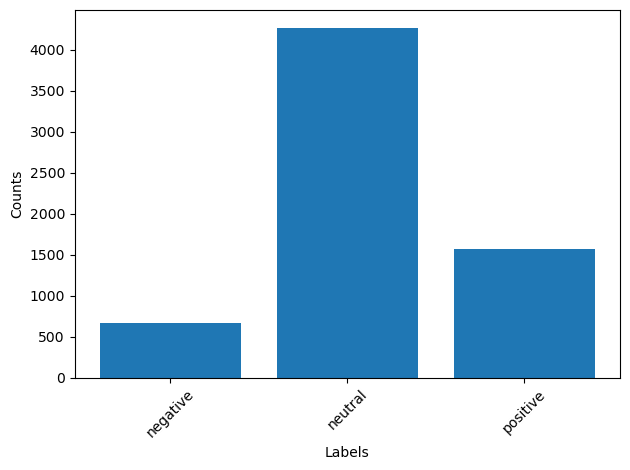

In [96]:
counts = Counter(sentiment_en)

categories = list(counts.keys())
counts_values = list(counts.values())

sorted_categories = sorted(categories)
sorted_counts_values = [counts[cat] for cat in sorted_categories]

# Create bar plot with sorted categories and counts_values
plt.bar(sorted_categories, sorted_counts_values)

plt.xlabel('Labels')
plt.ylabel('Counts')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h3>Selgitame manuaalse vaatamise põhjal välja, kumb sobib meile rohkem, kas VADER või BERTweet</h3>

In [97]:
#sentiment_sia_en - see on VADER'i labelite list
#sentiment_en - see on BERTweet'i labelite list

print(len(sentiment_sia_en))
print(len(sentiment_en))

6513
6513


In [106]:
sentiment_sia_en_replaced = sentiment_sia_en.copy()

In [98]:
len(sentiment_sia_en_texts)

6513

In [107]:
replacements = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}  # Define your replacements

sentiment_sia_en_replaced = [replacements.get(x, x) for x in sentiment_sia_en]

In [111]:
en_texts = texts_en.values()
mismatch_id = []

for i in range(len(sentiment_sia_en_texts)):
    VADER = sentiment_sia_en_replaced[i]
    BERT = sentiment_en[i]
    if BERT != VADER:
        mismatch_id.append(i)

In [112]:
len(mismatch_id)

3733

In [113]:
random_sample = random.sample(mismatch_id, 100)

In [115]:
human_annotation = []

for i in random_sample:
    print("Text:")
    print(sentiment_sia_en_texts[i])
    print()
    print("VADER:", sentiment_sia_en[i])
    print("roBERTa:", sentiment_en[i])
    # MÄRGIME ÜLES, KUMBAL MUDELIL OLI ÕIGUS -> VADER=1; roBERTa=2, mittekumbki=3
    human_annotation.append(input())
    print()

Text:
DEFEND NET NEUTRALITY IN EUROPE | Your freedom online is threatened by an EU proposal  NET NEUTRALITY IN EUROPEYour freedom online is threatened by an EU proposal.The fight for the open internet is happening right now in Brussels.Edit: Someone could translate the message in Estonian, so that I/we can send it to MEP @kajakallas

VADER: positive
roBERTa: neutral


 3



Text:
Question about smoking areas Hello. I am living in Tallinn and have a very bad habit of smoking, which I don't plan on quitting anytime soon. No one should smoke. Having said that, I am looking for comfortable places that are suitable for studying or working on my laptop that I also can smoke a cigarette without having to interrupt my work. Somewhere with coffee would be great. If anyone knows what I am talking about, could you give me some information?

VADER: positive
roBERTa: neutral


 2



Text:
Roppused Hello,The last time I went to stand up in Botik, most of the performances were in Estonian. I can understand Estonian to some level, however, slangs (cum, let's fuck, dickblocker, or asshole) were my weak points. Couldn't enjoy some jokes, because when I learnt what some words meant, it was late. So I am here to learn some good slangs ( roppused) along with their translation, and some famous "figures" in Estonian story ( like Martin Helme) people. My only goal is at the moment from this post to improve my standup understanding skills.

VADER: negative
roBERTa: neutral


 2



Text:
Share your unpopular opinion about Estonia(ns) In light of similar threads in other r/country subreddits, lets share UNPOPULAR opinions that you (foreigner or local) have about Estonia or its people.I'll bite:1) Kohuke is nothing special.

VADER: positive
roBERTa: neutral


 2



Text:
Is it okay to go naked with your family in sauna in estonia when you become adult or is it only okay when you are kid? 

VADER: positive
roBERTa: neutral


 2



Text:
Which second hand shops... 

VADER: positive
roBERTa: neutral


 2



Text:
Let's talk about the no-go zones Recently, I've begun to notice that, when asked about the "bad" areas of the country (and Tallinn in particular), many people here would usually mention Lasnamäe / Ida-Virumaa as their first choice. The reasoning being that these areas are mostly Russian-speaking and the overall socio-economic situation there is not that great. While is mostly agree with the latter, it still got me thinking. Having lived in Lasnamäe for  most part of my life, I never really thought of it as a ghetto or anything like that. I mean I've been mugged once in the 90s by some druggies, but apart from that one incident, it generally felt pretty safe. At least, not really any more dangerous than places like Põhja-Tallinn, Männiku or even the outskirts of Mustamäe, for example. Although I must admit that things might look a bit different from my perspective (I'm Russian).So is there really a general consensus among Estonian people that these places are best avoided or am I

 2



Text:
Recommend websites for job searching in Tallinn? I found a few trough Google, but not sure what you guys would recommend. Thanks in advance! 

VADER: positive
roBERTa: neutral


 2



Text:
Can someone who talks Estonian help me? Hello there. I have a 15 second video where i need to write what’s being told in it and the translation. Can someone give me a hand? Thanks.

VADER: positive
roBERTa: neutral


 2



Text:
What do estonians perceive as attractive? Been wondering about that, I've heard that in the nordic countries in overall, dark haired/dark eyes people with not-so-dark complexions tend to take the spotlight?By dark complexions I mean Italian, Greek, Brazilian(southern south america), Portuguese and Mediterranean in overall.

VADER: positive
roBERTa: neutral


 2



Text:
Good neighborhoods in Tallinn (again) I found a 3 years old [topic]( about it, and since it's quite old, I'm asking it again.I'm about to move to Tallinn next year and I'd like to know more about neighborhoods in Tallinn. I'll move with my girlfriend and we do like night life, pubs and etc. I'd like a recommendation of good places. Based on my research, I came with few options:* Uus Maailin* Kesklinn* Ilmarine* Vanalinn* Kadriorg* Kalamaja About rent price, 600EUR or 700EUR tops, but, of course, I'm looking for something cheaper. Thanks!

VADER: positive
roBERTa: neutral


 2



Text:
Please help me validate an Estonian translation I do not speak any Estonian. I wrote this article (in English) a couple years ago: the years people have sent translations of my article, including an Estonian translation. However, it seems I wasn't skeptical enough and some of these translations are machine-translated gibberish. Is the [Estonian translation]( reasonable or is it gibberish?

VADER: positive
roBERTa: negative


 2



Text:
NOA Chef's Hall Hi. Has anyone been to Noa, or Noa Chef's Hall? Would you recommend the experience? Any other comparable restaurants?

VADER: positive
roBERTa: neutral


 2



Text:
Learning Estonian for studying reasons.   Hello,   I have been accepted in TTU. Looking at the Integrated Engineering course programme I would prefer to change my degree into something more focused on electrical engineering.   If I start learning Estonian right now, is it realistic to achieve an academic level in Estonian within a year?

VADER: positive
roBERTa: neutral


 2



Text:
Need vhigh players 4 to make a temp team to enter a DOTA 2 Tournament at TTU/TUT August 16-18.  guys, I'm looking for 4 people to play with me at a tournament held at TTU/TUT. The entrance fee will be 16€ upon signup or 20 upon arrival. (I think it's per team? so it'll be 3.2 per person if we sign up early).Looking for: Smart captain (mostly for making in-game decisions)*Roles 1-3 and 4 or 5. I play 4 or 5.Requirements:   Very High Skill Bracket (you can even tell me your DBR if you have it) &amp; preferably over 400 wins    Friendly players - no ragers (I don't rage if there aren't any other ragers)  Must be able to pay the entrance fee  Must have a mic for VOIPAdd me on [Steam]( or PM me here.I'd like to practice sometime at night - after 6PM/18:00. edit: I fucked up the title. :( NEED 4 VHIGH PLAYERS TO MAKE A TEMP TEAM FOR THE DOTA 2 LAN TOURNEY AT TTU!*edit 2: TTU link 

VADER: positive
roBERTa: neutral


 2



Text:
Can someone please explain this Estonian song to me  not decipher the lyrics. Anyway, I heard it yesterday for the first time and it made me extremely thirsty.

VADER: positive
roBERTa: negative


 3



Text:
Place to eat dinner on Christmas Eve? Hi. So as the title says I am looking for a place to eat dinner on Christmas Eve in Tallinn. Can someone recommend something? Thank you.

VADER: positive
roBERTa: neutral


 2



Text:
Any advice for an American going to Tartu I am an American who be going to Tartu for some short term missions work in September. I was curious if anyone had anything interesting to advise about Tartu or Estonia in general? My family history is mainly from Estonia if you go back 4 generations or so, but I've never actually been. It will be interesting to see what it is like. I've heard everyone is quiet and has a dry sense of humor, so I should fit in rather well.Thanks.

VADER: positive
roBERTa: neutral


 1



Text:
Any tips for a day trip? A friend of mine and I are coming to Estonia for couple of days and we reserved a car for a day. Are they any tips for a one day trip with a car? Something historical sites or something with a nice view? It would be nice to see other places than Tallinn (not that there is anything wrong with Tallinn).I did check the sticky post, but it seemed to have more what to do in Tallinn in a short time.

VADER: positive
roBERTa: neutral


 2



Text:
I need your help - International research participation (Mater's thesis) 

VADER: positive
roBERTa: neutral


 2



Text:
Estonia vs Lithuania vs Latvia Hey guys!We are conducting a research to find out which of the 3 Baltic States youth (15 to 30) has better financial literacy and sustainability skills.    I CHALLENGE you to complete our survey and to find out for yourself how well did you do. It wil take you only about 5 to 8 minutes to complete it.  How about it? Are You up For the Challenge?! [  We are willing to share our results if we can manage to get the needed amount for the survey to represent the population.

VADER: positive
roBERTa: neutral


 2



Text:
Selling alcohol in Estonia? Tere!I don't know really anything about Estonia's legal system so I thought you guys could assist me a bit. Love the country though, you have what we Finns call "tekemisen meininki", a positive attitude towards doing things, while we Finns have all-innovation-killing, tax-'n'-paperwork-loaded shithole of a system. Your tax system is praised by ALL companies that move there from here.So, as many of you may know, selling alcohol (especially beer) here in Finland is practically impossible if you don't have thousands of euros, nerves and luck to go through the permit circus. Estonia is - to me - a sane place when it comes to alcohol politics, so I'd like to know what kind of restrictions and taxes do I have to fill/ pay if I come and sell my own beer and wine in Tallinn?I heard about the Sunday rule which says no alcohol selling on Sundays, but all else is unknown to me.Thanks!

VADER: positive
roBERTa: neutral


 2



Text:
Estonian version of "Suomen muotoisen pilven alla" by Arttu Wiskari A radio station in Finland played an Estonian version/cover of ["Suomen muotoisen pilven alla"]( by a Finnish artist Arttu Wiskari. Do you guys know what's the name of the Estonian version?I'm not proud I even have to ask this, but it's been in my head since this morning and I have to do something to get rid of this earworm.

VADER: negative
roBERTa: neutral


 2



Text:
About Estonian society, especially in terms of hierarchy and behavior  [ have read an article abt Estonian culture from the link above and i want to ask you guys, how correct it is.For particularly in terms of hierarchy , they cite:* Estonia is a hierarchical society.* Age, experience and position earn respect.* Older people are generally viewed as wiser and as a result revered and honoured. Elders are introduced first and in general are treated much like royalty.* Those in senior positions bear the responsibility to make decisions in the interest of the group.* Due to seniority titles are very important when addressing people.* It is expected that you will use a person's title and their surname until invited to use their first name.Also in Finnish part : [ they cite: ´´Finnish Egalitarianism* Finland is an egalitarian society, which is reflected in their language, which employs gender-neutral words.* Finns are very modest and downplay their own accomplishments.* They view being

 2



Text:
Before the fall of the Soviet Union, was Estonian and the other Baltic languages written in Latin script or Cyrillic? Was the current alphabet adopted in the 90s? It seems odd that Estonian/Latvian/Lithuanian would've stayed with a Latin script while in the USSR while a lot of the other languages were switched over into the Cyrillic alphabet.If the usage of the Latin alphabet predates the fall of the USSR, can anyone tell me why the Baltic languages used that as opposed to Cyrillic while the countries surrounding them did? Is it something to do with religion? I notice the orthodox countries aside from Romania all use Cyrillic but the Protestant and catholic countries like Poland or Czechoslovakia don't.Just curious, thanks!

VADER: negative
roBERTa: neutral


 2



Text:
Question about Estonian startups I'm studying Computer Science. In one of the subjects - Buissnes in IT, our professor spent a good while talking quite favorably about startups in small countries. He brought Estonia as a prime example.To keep things short, the content of a lecture was more or less that IT startups in small countries have no chance to achieve satisfactory profitability on a domestic market. So they are 'born global', they start with a goal of conquering foreign markets. As a consequence they have no need for painful transitions or radical changes in their buissness models.So here are the questions:Is this something that is talked about in Estonia?What are the prime examples of such companies that are known to you?

VADER: positive
roBERTa: neutral


 2



Text:
Spending new years eve in tallinn! Me and my friends need weed please dm! 

VADER: positive
roBERTa: neutral


 2



Text:
Help with buying a car ? Hey, we are expats, trying to buy a second hand car here, and many times we see companies that sell used cars, with deals that looks a little bit too good to be true.Problem is i have 0 understanding in cars, so i am not even sure how to check it.Lately we found some company that have really excellent deals( think Russians), name is : **ES Autod**, in street peterburi tee 71. (no reviews)Does anybody have experience with them ? any advice in the subject ? Thanks!

VADER: positive
roBERTa: negative


 2



Text:
Where can I buy body pillows here? It doesn't have to have some anime cover, just a plain white body pillow is fine.

VADER: positive
roBERTa: neutral


 2



Text:
When did Estonians start calling their country/people "Eesti"? Found this interesting response by a Finn in a [Quora thread]( *Virolainen/virolaiset* is the historical demonym for Estonian people in the Finnish language and several other Finnic languages. According to my knowledge, even Estonians didn’t use the word “eesti” before the Soviet rule — they referred to themselves as *maarahvas*(hilariously those words in Finnish would mean “lower country folk/peasants”) and their language was *maakeel*.&gt; I’m convinced that the word *eesti* was ultimately a Soviet invention although I haven’t studied the issue extensively.How true is this?Also, what is the etymology of *maarahvas*?

VADER: positive
roBERTa: neutral


 2



Text:
About Hara Submarine Base I'd like to go and see that submarine base, but i looked google street view and it shows that you can't go there with a car. Also it tells that theres a CCTY and that it's private property. Dies this mean i need to got by feet or I can't go at all? Who should i contact for permission?

VADER: positive
roBERTa: negative


 2



Text:
University of Tartu International Admissions Hello! I have doubts about the whole uniTartu situation now with the covid... And want to know if there is more that haven't got a reply of admissions department about the acceptance letter.

VADER: positive
roBERTa: negative


 3



Text:
I'm going to Tallinn tomorrow, and I would like some advice on restaurants, places to see etc. Hey Estonians, I'm from Denmark, and I'm going to Tallinn tomorrow for about 4 days. I already know about the old part of the city (and the stuff you can read in every tourist book or website).Do you have any recommendations on restaurants (we would like to try the Russian and Estonian/Baltic cuisine), or places of interest to see? Thanks in advance. PS. I'm an eager photographer, so photo-friendly places are very welcome. 

VADER: positive
roBERTa: neutral


 1



Text:
Can someone help me register for a .ee domain? I'm from the US and want to register a .ee domain for a personal site since my name is too common, so I was wondering if anyone would be willing to help since someone with an Estonian ID is required. Thanks!

VADER: positive
roBERTa: neutral


 2



Text:
Any US ex pats on here want to talk about your experiences? 

VADER: positive
roBERTa: neutral


 2



Text:
Is the letter ä in Estonian pronounced like the English phoneme /æ/? Or is it pronounced with a more open mouth than that? 

VADER: positive
roBERTa: neutral


 2



Text:
Accounting service in Tallinn Hi guys,it's almost 5 years since I'm living in Tallinn, 4 since  I opened my OÜ company.I've been always relying on the 1Office accounting services, but lately the quality is decreasing and the price is growing (now I'm paying like 170eur/m VAT included, I think it's way too much).Do you have any good accounting service to suggest? My company is super small (there's just me atm, my monthly transactions are usually less than 20).What I like of 1Office is that I can access ENVOICE for submitting my expenses and SmartAccounts for my invoices (where I also can see the overall financial situation). But for the rest nothing special.Many thanks for your help, cheers :)

VADER: positive
roBERTa: neutral


 1



Text:
Credit raiting in Estonia Hello guys,&amp;#x200B;I have a problem and I was hoping someone else has gone through something similar.Basically, I got myself into a pickle due to an invoice from Telia that I left unpaid. It's completely my own fault, i was abroad and I just forgot about it. I paid them back since.What I learned now is that my name is in some kind of  **MAKSEHÄIREREGISTER** and basically nobody is willing to give me a loan at all or rent me an apartment? I tried to lease a phone and they flat out refused, landlords are turning me away as well.This is completely ridiculous as the amount is minuscule compared to my net monthly earnings and I have a perfect payment history on my loan.Does anyone know what to do in this situation?   Should I contact a lawyer?Also, it seems like the register is a private company, does anyone know what legal ground they have to store my personal information?&amp;#x200B;Thank you for any advice.edit -spelling

VADER: positive
roBERTa: nega

 2



Text:
Need advice, I want to move to Estonia through career .&amp;#x200B;

VADER: positive
roBERTa: neutral


 2



Text:
Russia to Estonia: best transportation mode? Hi, I'm a non EU resident, I don't need a visa for the EU and I constantly travel to Europe. I usually enter the Schengen area through Spain.After doing some tourism in Russia, I would like to take a train or bus to Tallinn. I've read that crossing the border by bus isn't a good experience (because of customs and immigration process) and that train is much better. Do you know anything about this?I'm also an e-resident.

VADER: positive
roBERTa: neutral


 2



Text:
As a people known for being introverted &amp; blunt (but not rude), what is life like for people with Autism in Estonia? 

VADER: positive
roBERTa: neutral


 2



Text:
Need help identifying an old nursery rhyme? Hi, bit of a weird request, but can anyone tell me what the name of this nursery rhyme might be? My parents knew it from an old relative, but they only know a couple of the words. When they say it, it sounds to me like 'ola vola vec'. Given the age of this since long deceased relative, it would have to be very old (early 20th century or before). Very grateful to anyone who could help me with this!

VADER: positive
roBERTa: neutral


 2



Text:
Growing magic mushrooms in Estonia? 

VADER: positive
roBERTa: neutral


 2



Text:
which company to sell a house through? i inherited a house and would like to sell it, so i think i need a realtor for it as i do not really know what im doing. which company should be used for this? i'm sure they all have a reputation but ive never paid attention to them personally

VADER: positive
roBERTa: neutral


 2



Text:
Any tips for helping my Estonian friend move to Canada? Does anyone have any pointers on how to start the process of moving to Canada from Estonia?

VADER: positive
roBERTa: neutral


 2



Text:
Had my UT admission interview 3 weeks ago and I haven't heard anything yet, Should I be worried? 

VADER: negative
roBERTa: neutral


 1



Text:
A few questions Is Estonia a cold place?  What time do you recommend I invite my girlfriend to visit Estonia with me (e.g. New Years, Valentines, Summer?) ?  What city/cities and what historical places and beaches? :P&amp;#x200B;Also, anyone has a Raison account?

VADER: positive
roBERTa: neutral


 2



Text:
Looking to buy a home in Estonia. Need info on the fees. In the next year or so, my family and I will be moving to Estonia and hopefully looking to buy our first home.I understand that there are fees to pay, but I'd like to have a break down of who pays what and the amounts so I can budget for them. Anyone here have any good links for info? I'm struggling with my English only searches...

VADER: positive
roBERTa: neutral


 2



Text:
Can someone help from Tallinn? Good day,I'm Erasmus intern and my host company located in Tallinn. Currently, I'm not living in Estonia (because of remote internship). Due to Covid-19 situation, the Erasmus office from my university sends me a form where I need to indicate the address where I'm living in Tallinn. Can someone help with address(pm please), It's just needed for "protocol".P.s. I can send proof of my internship.

VADER: positive
roBERTa: neutral


 2



Text:
Buying an apartment in a commieblock a bad idea? 

VADER: negative
roBERTa: neutral


 1



Text:
Working opportunities while studying full-time Masters at Tallinn UT Hi Estonian Redditors,I am a 26\-years\-old computer engineer from a non\-EU country who has been working around for 3 years, but cannot speak Estonian language yet. I applied to the MSc Computer and System Engineering program at Tallinn University of Technology, and have been accepted by the institute. This is a full\-time MSc program with a duration of 2 years.To establish a financial support and to keep my experience and knowledge enhancing, in case of approving the admission offer and going to Tallinn, I would like to land a job at the same time.1\) On the "Working" page of the site Studyinestonia, [ , it is stated that international students in Estonia do not need an additional working permit while studying full time. So, once I am granted a residence permit and a type\-D national visa, I will also be claimed to gain a working permit, and won't need to deal with extra bureaucracy in order to gain it, right

 2



Text:
Living with 350 euros per month as a Masters student? Estonian government scholarship offers a monthly amount of 350 euros for living costs for master students , so I would like to know taking into account that University of Tartu and Tallinn university offer accommodation for 150 euros per month(with utilities costs included) would it be possible to survive with 200 euros per month for food (cooking instead of going out) and miscellaneous costs such as transportion and maybe going out once a month? 

VADER: positive
roBERTa: neutral


 2



Text:
Are there and Lan Parties/Gaming Events in Estonia? Been here for a bit but haven't heard of any. So I'm genuinely curious.

VADER: positive
roBERTa: neutral


 2



Text:
Buying used car. Inspection recommends. Tere, everyone, I’d like to buy a used car from Tallinn next week and export it. I’ve followed the advices on:  the seller on  and  check   as the car is imported and it doesn’t have registration plate. Checked the vin number on lkf.eeCan you recommend me a good place that can inspect the car before I buy it? Is it generally accepted to ask the seller to take the car for inspection? Any other advices are welcome too.Many thanks

VADER: positive
roBERTa: neutral


 2



Text:
A question about universities in Tallinn. I'm looking to do a survey at a couple of Tallinn universities. Taltech might be among them. I'd be asking students a prepared set of questions.   1, which university has the most exchange students from outside of Europe?  2, When is exam period, I don't want to interupt students who are rushing to take exams?  3, what time of day is the best time to catch students who are not in class but still at the university grounds? For example, hanging out by the front of the university or in a common area/benches. The point is to catch them when they're outside of class, not busy studying.   Cheers.

VADER: negative
roBERTa: neutral


 2



Text:
Not from Estonia, getting tattooed in Tallinn, wondering about ettiquete Tere! I just have a couple questions. I've gotten a few tattoos in the US but this is my first one abroad. I want to make sure I behave well for my artist and know what's expected.Is it customary to tip for tattoos in Estonia? If so what percentage should I leave the artist?Also, is it normal to get a free touch up after a few weeks to make sure the work is good, or will I have to pay for that? Anything else I should know? Thank you so much for any help, my apologies for not writing in Eesti keel, I don't know very much of it :(

VADER: positive
roBERTa: neutral


 2



Text:
What would be the Estonian equivalent of "let's fucking go!" ? 

VADER: neutral
roBERTa: negative


 1



Text:
The Russians have become more delusional. 

VADER: neutral
roBERTa: negative


 2



Text:
Questions about children books Hello people!A Latvian here.When I was a kid, I read two Estonian books which I quite liked. I can't recall their names. Maybe you can help me?- One was about a little brother and an older sister, who live in Tallinn. they go to school. That's about all I remember. Though there was one pretty remarkable picture, where they both are flying (in a dream) over Tallinn, above the towers of the Old Town, holding each other's hand. Does that sound familiar?- The other one was about a family of giants. A giant fellow married a giant lady and they had kids. They also had a motorcycle, but in order to go around with all his giant family the fellow had to use airplane fuel. Any clues? (Though I am not sure that the last one was an Estonian book, it might had been Finnish too).Anybody?

VADER: positive
roBERTa: neutral


 2



Text:
Hello!1 I'm not sure if this is the right sub for this but 

VADER: negative
roBERTa: neutral


 2



Text:
Driving license theory test Tere,I just moved to Estonia and my Indian driving license will only be valid for a year it seems. I read that in order to get an Estonian license, I need to pass a theory and practical driving test. Practical is fine but what is the theory test? Is it just common sense or does it need some preparation?The mnt.ee just asks to read through the [traffic act](

VADER: positive
roBERTa: neutral


 2



Text:
Question about Engineering Physics MSc in TTU Hello,I applied Engineering Physics but i do not know what to remember before interview and prepare for studying. Is there any one accepted/finished this section? Any help accepted with pleasure :)

VADER: positive
roBERTa: neutral


 2



Text:
Is the aurora borealis visible in or around Tartu? Tere!   If they can be seen here, then when might they be visible? Will I have a better chance if seeing them by traveling to a less light polluted city like Otepää?

VADER: positive
roBERTa: neutral


 2



Text:
Which is the most popular team sport in Estonia? Finland is ice hockey, Latvia is ice hockey and basketball and Lithuania is basketball, which one is in Estonia? (Singing choirs and Eurovision aren´t sports, sorry) 

VADER: positive
roBERTa: neutral


 2



Text:
Which bank should I choose ? Hello everyone. After settling in Estonia a few months ago, I now have to create a bank account in an Estonian bank. My new workplace absolutely want an Estonian account.I tried to do my own research and I noticed there are not a lot of  truly Estonian owned banks. In tartu the most common ones would be Swedbank and SEB I guess, both swedish.I really think it's better for the country to store my money in Estonia , so I would like a truly Estonian bank.It seems that's LHV could be a good choice, what do you think ? Do you have any advice ? Thanks a lot for your help!

VADER: positive
roBERTa: neutral


 2



Text:
Device test lab in Tallinn? Hi, I want to check few HTML5 browser games in mobile and console browsers. Is there place in Tallinn, to do so?

VADER: positive
roBERTa: neutral


 2



Text:
Where to buy 3G or 4G pre-paid (no contract) data sim for iPad mini as a tourist in Estonia? Tere,I am visiting Estonia (from Australia) for a month over June/July, and want to use my [iPad mini with Retina display on 4G] ( while I am there. Could anyone please recommend any Estonian service providers/carriers who have pre-paid data deals that don't require a contract? I want to get the nano-sim with an amount of data to use up in a short time - for example 2GB for €30.Does this exist? Thank you for your reply! Suur-aitäh! Head aega!

VADER: positive
roBERTa: neutral


 2



Text:
Estonia Student Life I have a plan to go to Estonia as a student one day, I really don't know when, But meanwhile I like to know more about Estnoia, I already searched google enough, But I think better to get information from redditers.My questions are as follows,1. Can I work in Estonia without knowing their langauge? ( I heard they speak english well, specially the youth)2. Are there part time jobs for International students in Estonia3. Is the P/T job salary enough to survive in Estonia?well, I have heard that Estonian girls are very pretty and they are very caring for their life patner as well. Anyways this is addtional fact though, I am waiting for your hearings for this post. Thank you..

VADER: positive
roBERTa: neutral


 2



Text:
Travelling by car from the Netherlands to Tallinn on the 3th of August. Hey! So I (dutch guy) wanted to visit my GF who works in Tallinn during this summer holidays. I'm planning on going by plane, but she says it'll be better if I go by car. This is so we have easier transport while I'm in the country.        My plan is to arrive in Tallinn on Friday the 4th of August and leave at Friday 11th.        Going by plane is much cheaper for me. Except for when someone wants to travel with me by car. I already added a ride on [blablacar]( If I'm going by car I'll drive away at the 3th of August, spend the night in Lithuania, and on the 4th I will arrive in Tallinn. On the 11th I will drive from Tallinn back to the Netherlands.        For this journey I ask 130 for gas. However, this is negotiable.        

VADER: positive
roBERTa: neutral


 2



Text:
Is Viljandi worth visiting? Hello ! I'm from Latvia and i'm going to go to Estonia in 2 days.  I have a day to spare , and i have a plan to go to Viljandi then. But i don't know if it is worth it , as i have heard from very few people . Any tips?

VADER: positive
roBERTa: neutral


 2



Text:
Married to an Estonian- advice on signing up for territorial defence roles Hi all.I'm looking for information on any territorial defence equivalent groups/Training programs in Estonia.My Estonian mother in law asked me if I would fight the Russians were there a need be. Obviously as someone that now eats at the table of Estonia; it's would be my duty to defend my new family. I want to be useful where possible.I'm not a soldier or a combatant of any kind, but I've been shooting since I was 5 of age. Any advice or information would be appreciated.

VADER: positive
roBERTa: neutral


 1



Text:
A dirty counting rhyme in Estonian? (sorry if question is stupid or inappropriate)  So, back in the days my schoolmate (he later went back to live in his native Tallinn) used to recite a puny little counting rhyme in Estonian, saying it was sort of well-known, and that it translated roughly to "One two three - there's hair growing on the ass".   Well, I certainly could make it as far as "Üks Kaks Kolm", but I can't remember the rest, and - was it really a thing?

VADER: negative
roBERTa: neutral


 2



Text:
Can you help me on a project about the EU by recording a short video of yourself saying a few things about the EU? Hello guys, I'm a portuguese student that is working on a project about the EU. My vision is to get one person from each EU country to answer, in video, why you think the EU is a community of values. A short sentece so the video doesn't get too long is all I need. Thanks for any help!Reach me out via PM or email that Ill give you privately.

VADER: positive
roBERTa: neutral


 2



Text:
why estonians hate the scottish and welsh BUT love the ENGLISH 

VADER: positive
roBERTa: negative


 2



Text:
Any physicians here? Question about ultrasound So im physician from Russia and i cant find my specialty in Estonia, can you help me figuring it out? What i do in Russia is called functional diagnostics - i read all ecg, echocardiogram, perform ultrasound and  holter monitoring. Thanks in advance

VADER: positive
roBERTa: neutral


 2



Text:
From the Militarization of the Economy to Threats from Outer Space 

VADER: negative
roBERTa: neutral


 2



Text:
Admission exam for Cybersecurity Bachelor Program at Taltech Hi everyone! If anyone here did the admission exam for the Cybersecurity bachelor program at Taltech, could you please tell me what's in it and how can I prepare for it?I am currently in an IT high school in Italy (high schools here are separated by the main subject you wanna take) and I have a good knowledge of python and java, I also know a bit about Html, css and JavaScript.I'm also studying Networking and Operative Systems and I have a good knowledge about virtual machines too.I already obtained a Cisco IT-essentials certification and I'm currently enrolled in the Cisco CCNA course, which I'm gonna finish this year.Is all this useful for passing the test or not?If someone could tell me where I can take sample tests or where I could practice for the test, it would be really helpful!I'm planning on applying for the 2022/2023 program.Thx ✌🏻

VADER: positive
roBERTa: neutral


 2



Text:
Winter boots and tailor recommendation Tere,Winter is coming and as a brand-new inhabitant of Tallinn I need to get myself a pair of winter boots, as well as good socks. I was wondering if you guys would have any boots recommendations ? I'm looking for something that is both stylish and that lasts long - I'm willing to pay the necessary price. And maybe a specific sock brand that's good for the cold?I'd also like to know if anybody knows a tailor with a fair price around the city? My jacket has ripped off and I wanna get it fixed and I'd like to get the cuffs of some of my pants hemmed/shortened and I've no idea where to find someone who could it for me - I suck at this kinda stuff so I wouldn't trust myself to do it. Would you guys know about anyone or a company or whatever who could provide these services?Suur äitah!

VADER: positive
roBERTa: neutral


 1



Text:
Shop for buying electronics in Tallinn? I'm trying to find shops that sell electronics in Tallinn (I'm talking electronic components, not appliances like Euronics, Klick, etc), to be specific I need to buy a Voltage converter (transformer) from 110v to 220v, the only electronics place I've seen is the LEMONA electronics near kristiine keskus but they don't have it and searching on the web without estonian knowledge is hard as it keeps ending up in euronics and so on :P so I need some tips of other big stores to search for electronics in general (I also eventually will need a multimeter and some semiconductors etc, so would be good to know of some big electronics stores for future reference).Thanks!

VADER: positive
roBERTa: neutral


 2



Text:
Question about Rights of E-Residents I apologize if you guys do not like foreigner questions about e-residency. If this isn't the proper place to ask this question, please direct me accordingly.I have an interest in both technology and law, and I recently found out about Estonian e-residency and e-services. In my research, I could not figure out a big thing. **What are the actual rights of e-residents?** I know e-residency does not confer citizenship or residency. I also know that practically speaking you can use the e-services, but when I looked into various Estonian laws ([available in English online]( I could not find a single guarantee. § 20^10 of the Identity Documents Act seems to allow public or private service providers discretion in refusing to deal with e-residents. I can't tell if § 20^10 (2) limits public service refusal in only limited cases (English should be "may only [restrict]" rather than "may [restrict]").  Say you had a bank account or a contract with an Esto

 2



Text:
How do I buy tram tickets at Linnahall station? I have to get the tram to Bussijaam early tomorrow but after looking at the tram station beside my hotel I don’t see a ticket machine? I don’t have any travel card just good old fashioned euros

VADER: positive
roBERTa: negative


 2



Text:
about salary I want to ask you something.  I will come to Estonia to work.  what is the average and minimum salary in the country?

VADER: positive
roBERTa: neutral


 2



Text:
Which cities/towns do you will grow and develop the most in Estonia in the future?  Which cities/towns do you will grow and develop the most in Estonia in the future?

VADER: neutral
roBERTa: positive


 2



Text:
Principal activity of a company Tere. When registering a new private limited company in Estonia I need to select a principal activity which is main source of revenue. The company can have other activities but I wonder how it is regulated. For example if the company creates software it is 62011 code (Computer programming activities) in EMTAK. But if it also does software consulting it is 62021. Now if the company want to diversify the assets and buy a property or ETFs it will be a different activity. Should I register different companies for each of these activities? I want to create software products, offer software consulting and re-invest part of the revenue in buying stock indexes and other securities.

VADER: positive
roBERTa: neutral


 2



Text:
Last Day in tallinn and just Wann talk to some Lokals! Yeah I am the recent few hours in tallinn and didn't really have any chances to talk to locals. So I guess wanna meet ⠀up and just talk a bit?

VADER: positive
roBERTa: neutral


 2



Text:
Can anyone recommend me an Estonian website that delivers flowers, chocolate and other stuff? Preferably written in English too. Good afternoon,&amp;#x200B;I would like to order flowers and (if possible) chocolate to be delivered in Tallinn, since my girlfriend is going to stay in your beautiful country till the end of January.Well, it would be great if I could order a bottle of wine too...unfortunately, I don't understand Estonian at all. Can anyone link me a website written in English, if possible?&amp;#x200B;If it's not possible, maybe someone knows a reliable website written in Estonian... I would use google translate, I guess.

VADER: positive
roBERTa: neutral


 1



Text:
How do you say ‘no thank you’ or it’s equivalent in Eesti Keelt? Like when someone asks if you want something? A lady asked if I wanted a küpsis and I felt like Ei or Ei taha is kinda rudez.

VADER: positive
roBERTa: negative


 3



Text:
Silver/Grey hair salon HELP! Hey, I want to blend my grey hair into dyed hair but a few of the salons I've contacted said that they can't/won't do silver or grey processing. Anyone know of any in or near Tallinn?? 

VADER: positive
roBERTa: negative


 3



Text:
So Chinese nationalists, in Estonia, are flagging my videos with false claims. 

VADER: neutral
roBERTa: negative


 2



Text:
How are cryptocurrency gains taxed? Is the tax rate 20% for capital gains in general? Is it also the same for receiving dividends?

VADER: positive
roBERTa: neutral


 2



Text:
Soon to be tourist wondering what the covid restrictions are at bars / clubs Do you have to wear a mask inside bars / clubs?What time are they open until? Thank you!

VADER: positive
roBERTa: neutral


 2



Text:
Advice for renting direct from owners Hi guys new to reddit and also going to be new to Tallinn. I'm moving to Tallinn at the start of June for work and am really struggling to find a place to stay (room to rent) within my budget, as the company I am going to work for is paying me a crap wage (just using them as a stepping stone till I find a better job and can afford a better gaff).I've signed up to all the FB pages but not really getting anywhere as it all seems to be student digs and since I'm older (37) and will be working full time, I don't think that will suit me very much.Has anyone any links to sites where you can rent rooms etc direct from the owner, without having to pay the agency fees and all that?Any advice would be appreciated :)

VADER: positive
roBERTa: neutral


 3



Text:
Does Estonia do April Fool's day? Got this email about the e-Residency program "Our foreign representations will be technically ready to take your applications from 1 April 2015. In the first weeks you will still be required to come to the office twice (once to apply and then again to get the card). Starting from May 2015 aka soon it will become much easier: you can then fill out an application online ahead of time and only come in yourself once."I know it's probably genuine but I thought it was funny they choose April 1st. 

VADER: positive
roBERTa: neutral


 2



Text:
Being a captian of your own yacth Hello everyone! I am curious about is there any education for certificate for being a captain and sailing in Tallinn (of course in English). First education/certificate then i am planing to buy a yacht(small one). Any idea, help, tips?Thank you a lot.Editing:Typo*

VADER: positive
roBERTa: neutral


 2



Text:
Where to find sushi-grade fish in Tallinn? You can't make sushi with just any raw fish, it has to fit a certain grade. I can't find any stores that sell fish marked as sushi grade. Anyone have a lead? Thanks!

VADER: positive
roBERTa: neutral


 2



Text:
Hi everyone, I have a question about gun licenses in Estonia. A friend of mine likes going to shooting ranges and using the guns that the ranges provide. He decided that he would like to have his own gun when going to ranges instead of renting each time.Can a non EU national, who has the right to live in Estonia, obtain a gun license (after having their background check cleared, does the first aid course, passes medical check, passes gun training course)? I have not seen any restrictions towards that in the law, but I wanted to double-check for him.

VADER: positive
roBERTa: neutral


 2



Text:
So if Estonia has such an advanced e-governance system and IT sector, why is there no significant economic growth? Tere!I was wondering about this thing, since Estonia is so often mentioned as an example of a perfect digital age country and a bulwark of useful IT developments in the governance. The [New Yorker called it "the Digital Republic"]( [Wired magazine named it as the "most advanced digital society in the world"]( and hence it's even a founding member [of the D5]( since 2013, the economic growth is so sluggish that it's barely noticeable in the numbers. Despite being the best-placing economy at the time when the Baltic states gained their independence from the Soviet Union, now Lithunia is even a bit ahed of Estonia in terms of GDP/capita (and the first things that come to my mind about Lithuania are basketball and high suicide rates - none of which should rationally contribute to overtaking a highly digitalized society). Factors like corruption, high government debt, a 

 2



Text:
Need advice on buying real estate in Tartu Context: we are an Estonian/American couple who need a semi-permanent base close to the center of town for business reasons (do not have or want a car). We have been living in 30 square meters for too long, so looking for 45 s.m. up. Budget is up to 120,000 Euros.1. Is this a good time to buy?2. Are there common pitfalls?  things to look out for?3. Should we look at newer buildings only?4. Are we likely to recoup our investment if we have to leave in 5/10 years?5. Interested chiefly in Karlova, Kesklinn, and Suppelinn. Should we consider other areas too?EDIT:  We have found some apartments in buildings that we like. How do you get "comps" here (the prices for which the other units in the building sold)?Thanks in advance for your advice and time.

VADER: positive
roBERTa: neutral


 2



Text:
Thinking of moving to Estonia Hi everyone,I've been reading this subreddit for the last couple days, and it has helped a lot, but I still have a question.&amp;#x200B;First of all, I'm a 26 years old lawyer from Brazil and, after doing some research online I'm thinking about moving to Estonia.My plan is to get a Master's in either Tartu or Tallinn, and the main options for me are International Business Administration and IT Law.&amp;#x200B;What worries me is that I'm not originally from a tech but from a business background, and it might be hard to get a job, since being a lawyer in a foreign country does not exactly mean anything.&amp;#x200B;Do you think that any of the Master's I'm thinking of would help me get a job in Estonia? Which one do you think would do better?Thanks a lot guys,&amp;#x200B;Vexy

VADER: negative
roBERTa: neutral


 2



Text:
Ordering items from French amazon If i wanted to order a pair of headphones from amazon.fr do i have to pay extra taxes or not since France is in European union? Sorry for a silly question 

VADER: positive
roBERTa: neutral


 2


In [116]:
the_most_accurate = Counter(human_annotation)
the_most_accurate.most_common(1)[0][0]

'2'

In [117]:
all = sum(list(the_most_accurate.values()))
values = list(the_most_accurate.values())
results = [values[0]/all, values[1]/all, values[2]/all]

<h5>Näitame graafikuga, milline mudel oli täpsem</h5>

<BarContainer object of 3 artists>

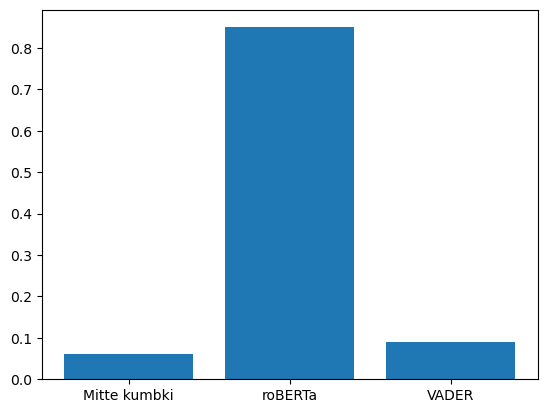

In [118]:
plt.bar(['Mitte kumbki', 'roBERTa', 'VADER'], results)